In [1]:
import pandas as pd


feature_name_df = pd.read_csv("./datasets/human_activity/features.txt", sep="\s+",header=None,
           names=["column_index", 'column_name'])

In [2]:
feature_name_df.head(3)

,column_index,column_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z


In [3]:
feature_name = feature_name_df.iloc[:,1].values.tolist()

In [4]:
feature_dup_df = feature_name_df.groupby("column_name").count()
print(feature_dup_df[feature_dup_df["column_index"]>1].count())
feature_dup_df[feature_dup_df["column_index"]>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [11]:
feature_dup_df = feature_name_df.groupby("column_name").count()
print(feature_dup_df[feature_dup_df["column_index"]>1].count())
feature_dup_df[feature_dup_df["column_index"]>1].head()


def get_new_feature_name_df(old_feature_name_df):
    #column_name으로 중복된 컬럼명에 대해서는 중복 차수 부여, col1, col1과 같이 2개의 중복 컬럼이 있을 경우 1, 2 
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    # feature_dup_df의 index인 column_name을 reset_index()를 이용하여 컬럼으로 변환. 
    feature_dup_df = feature_dup_df.reset_index()
    # 인자로 받은 features_txt의 컬럼명 DataFrame과 feature_dup_df를 조인. 
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    # 새로운 컬럼명은 앞에 중복 차수를 접미어로 결합. 
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                           if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./datasets/human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 feature명을 새롭게 수정하는 get_new_feature_name_df()를 이용하여 새로운 feature명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./datasets/human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./datasets/human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./datasets/human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./datasets/human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()


column_index    42
dtype: int64


In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


In [14]:
y_train["action"].value_counts()

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train,y_train)
dt_pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, dt_pred)
print(accuracy, dt_clf.get_params())


0.8547675602307431 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [23]:
from sklearn.model_selection import GridSearchCV

params = {"max_depth" : [6,8,10,12,16,20,24]}

grid_cv = GridSearchCV(dt_clf, param_grid=params,scoring="accuracy", cv=5,verbose=1)
grid_cv.fit(X_train,y_train)
grid_pred = grid_cv.predict(X_test)
grid_accuracy = accuracy_score(y_test,grid_pred)
print(grid_accuracy,grid_cv.get_params)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
0.8574821852731591 <bound method BaseEstimator.get_params of GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=156),
             param_grid={'max_depth': [6, 8, 10, 12, 16, 20, 24]},
             scoring='accuracy', verbose=1)>


In [28]:
best_dt = grid_cv.best_estimator_
best_dt

DecisionTreeClassifier(max_depth=16, random_state=156)

In [25]:
result = best_dt.predict(X_test)
result

array([5, 5, 5, ..., 2, 1, 1], dtype=int64)

In [26]:
accuracy_result = accuracy_score(y_test,result)
accuracy_result

0.8574821852731591

In [27]:
best_dt.get_params(0)

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 16,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 156,
 'splitter': 'best'}

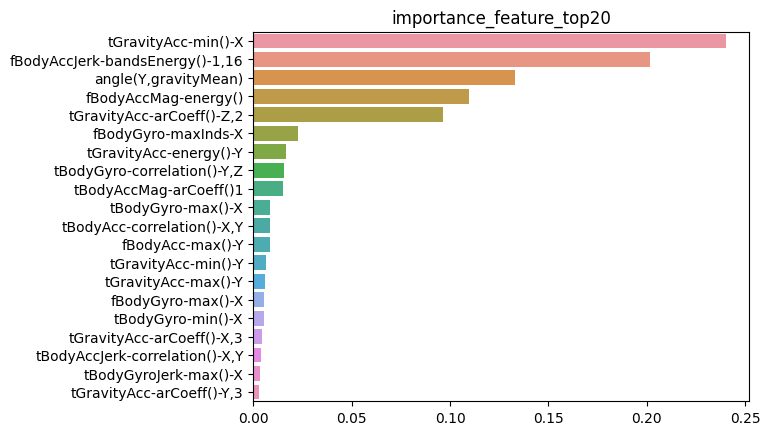

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

importance_feature = best_dt.feature_importances_

importance_feature = pd.Series(importance_feature,index=X_train.columns)

impo_feature_top20 = importance_feature.sort_values(ascending=False)[:20]


plt.title("importance_feature_top20")
sns.barplot(x=impo_feature_top20, y=impo_feature_top20.index)
plt.show()